In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy.stats import zscore
from sklearn.impute import KNNImputer
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy import stats
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

In [4]:
from pathlib import Path
print(Path.cwd())

from os import walk

#This is the folder path, replace to your own local path
dir_path = r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Sang_Code_Processing_2024\0. Raw data\Year 4Final\Desigo\Facade Temperature'

file_list = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    file_list.extend(file_names)
    # don't look inside any subdirectory
    break
print(file_list)

c:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Code Year4
['HZ_East_facade_high_temp_060123-053124_raw.csv', 'HZ_East_facade_low_temp_060123-053124_raw.csv', 'HZ_North_facade_high_temp_060123-053124_raw.csv', 'HZ_North_facade_low_temp_060123-053124_raw.csv', 'HZ_South_facade_high_temp_060123-053124_raw.csv', 'HZ_South_facade_low_temp_060123-053124_raw.csv', 'HZ_South_facade_mid_temp_060123-053124_raw.csv', 'HZ_West_facade_high_left_temp_060123-053124_raw.csv', 'HZ_West_facade_high_right_temp_060123-053124_raw.csv']


In [5]:
#IMPORTANT: If you get an error in reading the files do the following:
import os
Lst = []
for i in range(0, len(file_list)):
    # Construct the full path for each file
    file_path = os.path.join(dir_path, file_list[i])
    # Use the full path to read the CSV file
    data = pd.read_csv(file_path, parse_dates=['Timestamp'], index_col=[0])
    filtered_df = data[data['QualityGood'] == True]
    print(len(filtered_df))
    Lst.append(filtered_df)

527023
527024
527028
527031
527029
527028
527031
527024
527021


In [6]:
Lst_Temp = []
Lst_name = []
Zone_Temp = pd.DataFrame()
res = 1
#Loop through the data frames
for i in range(0,len(Lst)):
    #Convert the index of the current DataFrame to datetime format with UTC timezone
    Lst[i].index = pd.to_datetime(Lst[i].index, errors='coerce', utc=True)
    #Convert the timezone of the index from UTC to US/Eastern
    Lst[i].index = Lst[i].index.tz_convert('US/Eastern')
    #Resample the DataFrame to a 1-minute frequency using the mean for aggregation. (This is for analysis)
    #forward fill missing data resulting from the resampling.
    Lst[i] = Lst[i].resample("1T").mean().ffill()
    #Extract the name of the first column of the DataFrame.    
    zone_name = Lst[i].columns.values[0]
    Lst_name.append(zone_name)
    #Convert the specified column's data to numeric to ensure consistency for calculations.
    Z = pd.to_numeric(Lst[i][zone_name])
    Lst_Temp.append(Z.tolist())
    #Create a new column in 'Zone_Temp' with the name of the current zone.
    Zone_Temp[zone_name] = pd.Series(Z, index=Lst[i].index)
    
Zone_Temp

C:\Users\Sang\AppData\Local\Temp\ipykernel_17168\1714712622.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_17168\1714712622.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_17168\1714712622.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_17168\1714712622.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_17168\1714712622.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version,

East_facade_high_temp  East_facade_low_temp  \
Timestamp                                                                
2023-06-01 00:00:00-04:00             -69.620796             64.464783   
2023-06-01 00:01:00-04:00             -69.620796             64.425171   
2023-06-01 00:02:00-04:00             -69.620796             64.444977   
2023-06-01 00:03:00-04:00             -69.620796             64.405380   
2023-06-01 00:04:00-04:00             -69.620796             64.246979   
...                                          ...                   ...   
2024-05-31 23:55:00-04:00             -68.927795             60.742386   
2024-05-31 23:56:00-04:00             -68.927795             60.603790   
2024-05-31 23:57:00-04:00             -68.927795             60.583984   
2024-05-31 23:58:00-04:00             -68.927795             60.643387   
2024-05-31 23:59:00-04:00             -68.927795             60.623581   

                           North_facade_high_temp  North_facade_low_temp  \
Timestamp                                                                  
2023-06-01 00:00:00-04:00               64.187576              64.048981   
2023-06-01 00:01:00-04:00               64.207367              64.147980   
2023-06-01 00:02:00-04:00               64.088577              63.989578   
2023-06-01 00:03:00-04:00               64.108383              64.029175   
2023-06-01 00:04:00-04:00               64.029175              63.910385   
...                                           ...                    ...   
2024-05-31 23:55:00-04:00               61.059174              59.257378   
2024-05-31 23:56:00-04:00               61.098785              59.178192   
2024-05-31 23:57:00-04:00               61.217590              59.197975   
2024-05-31 23:58:00-04:00               61.197784              59.178192   
2024-05-31 23:59:00-04:00               61.276978              59.197975   

                           South_facade_high_temp  South_facade_low_temp  \
Timestamp                                                                  
2023-06-01 00:00:00-04:00               64.167786              64.880585   
2023-06-01 00:01:00-04:00               64.147980              64.860779   
2023-06-01 00:02:00-04:00               64.108383              64.880585   
2023-06-01 00:03:00-04:00               64.147980              64.801376   
2023-06-01 00:04:00-04:00               64.147980              64.840973   
...                                           ...                    ...   
2024-05-31 23:55:00-04:00               61.692780              59.574181   
2024-05-31 23:56:00-04:00               61.732376              59.712784   
2024-05-31 23:57:00-04:00               61.831375              59.653381   
2024-05-31 23:58:00-04:00               61.851181              59.692978   
2024-05-31 23:59:00-04:00               61.989777              59.732590   

                           South_facade_mid_temp  West_facade_high_left_temp  \
Timestamp                                                                      
2023-06-01 00:00:00-04:00              64.603378                   63.831177   
2023-06-01 00:01:00-04:00              64.583572                   63.989578   
2023-06-01 00:02:00-04:00              64.563766                   63.910385   
2023-06-01 00:03:00-04:00              64.524185                   63.751984   
2023-06-01 00:04:00-04:00              64.543976                   63.791580   
...                                          ...                         ...   
2024-05-31 23:55:00-04:00              60.484970                   60.564178   
2024-05-31 23:56:00-04:00              60.465195                   60.544373   
2024-05-31 23:57:00-04:00              60.564178                   60.564178   
2024-05-31 23:58:00-04:00              60.564178                   60.722580   
2024-05-31 23:59:00-04:00              60.564178                   60.722580   

                           West_facade_high_r

<Axes: xlabel='Timestamp'>

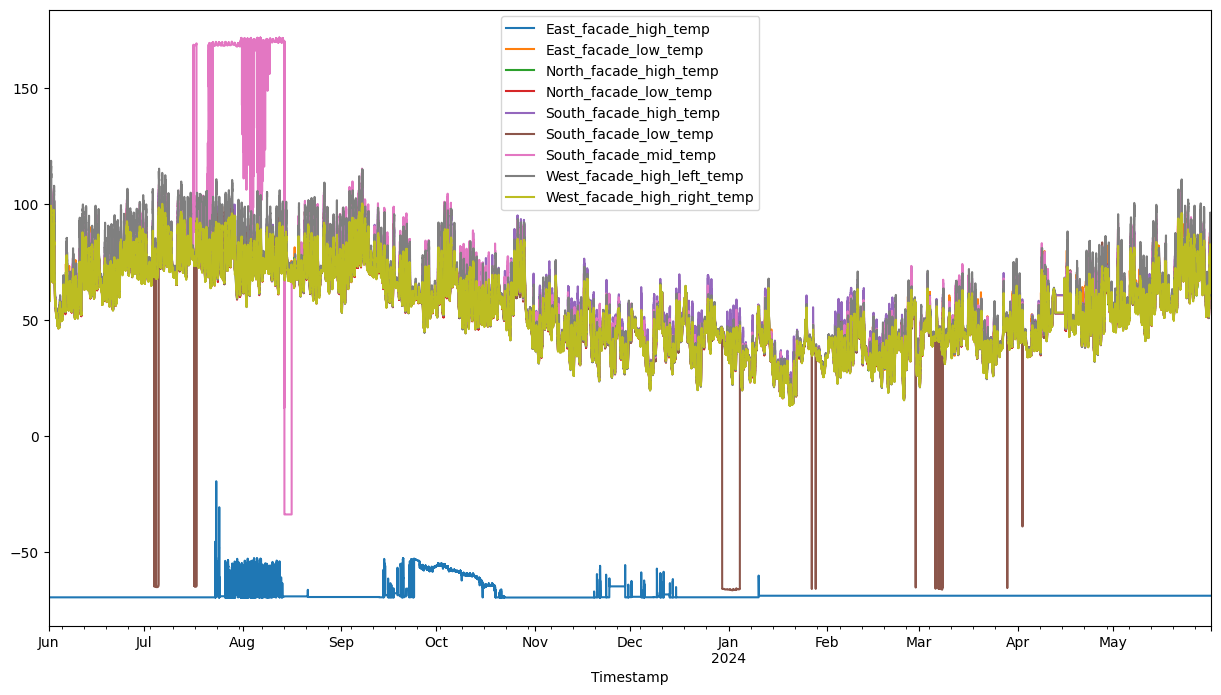

In [7]:
Zone_Temp.plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

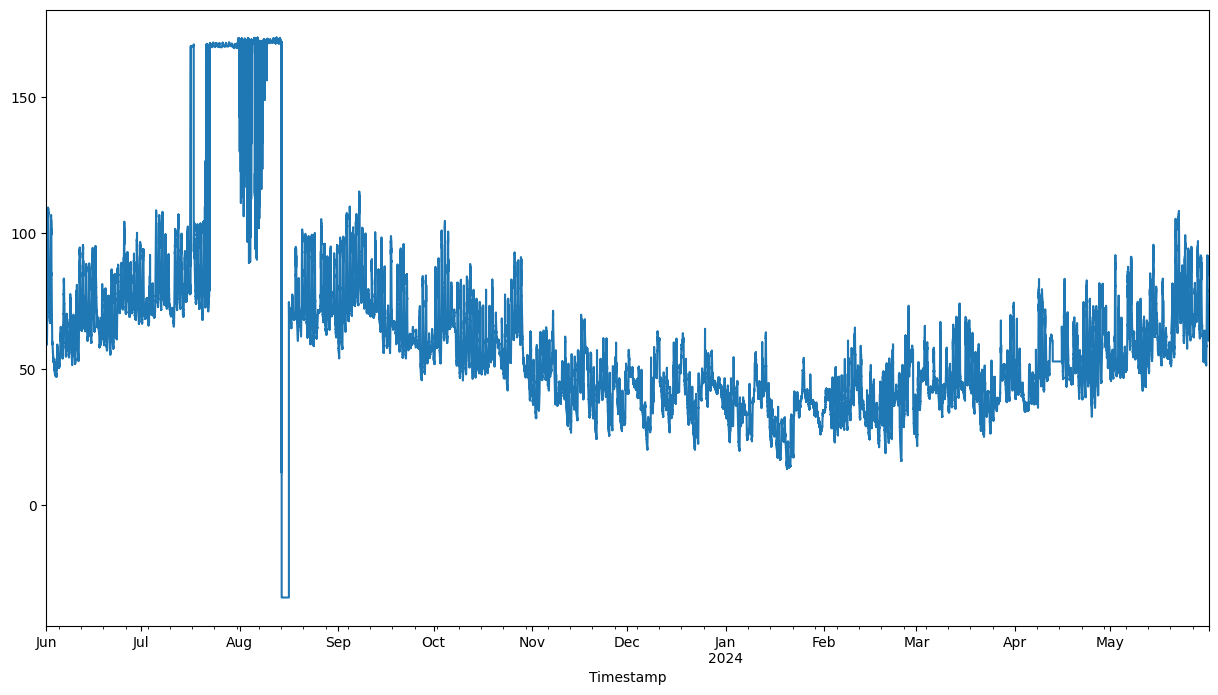

In [8]:
Zone_Temp['South_facade_mid_temp'].plot(figsize=(15, 8))

In [9]:
#manual removal
Zone_Temp[(Zone_Temp > 115) | (Zone_Temp < 0)] = np.nan

<Axes: xlabel='Timestamp'>

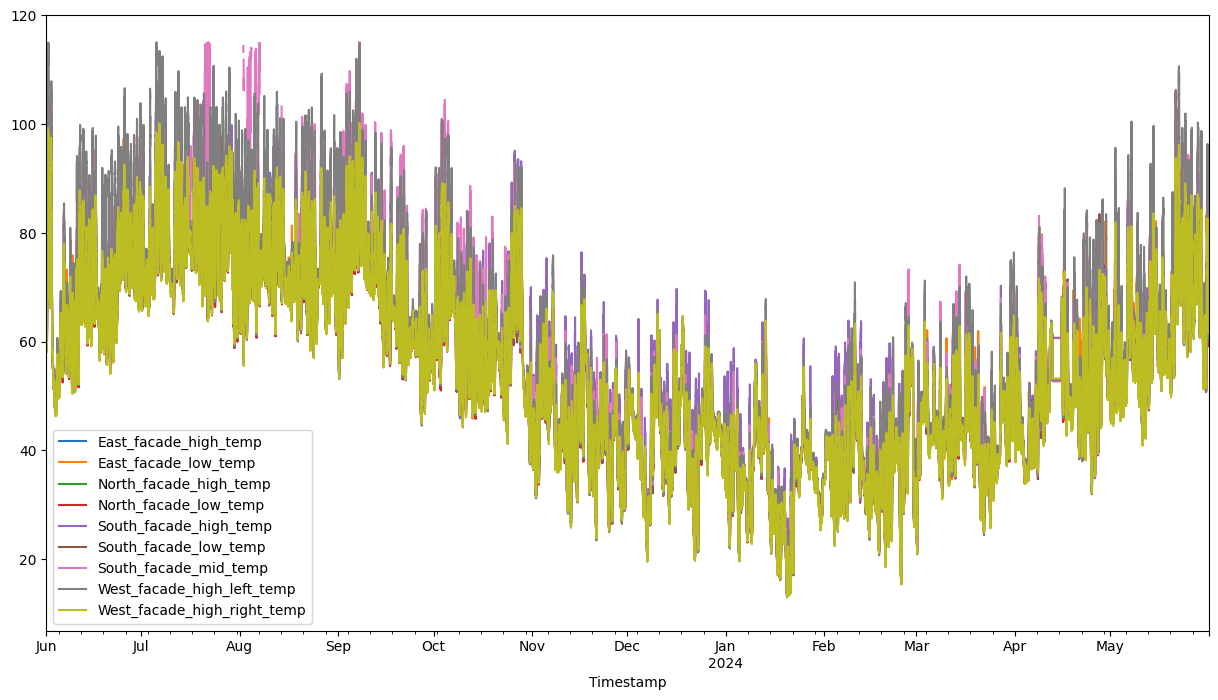

In [10]:
Zone_Temp.plot(figsize=(15, 8))

In [11]:
#Difference Analysis
Lst_diff = []
Lst_name = []
#Loop through each DataFrame to calculate and store differences in data.
for i in range(0,len(Lst)):
    zone_name = Lst[i].columns.values[0]
    Lst_name.append(zone_name)
    Z = pd.to_numeric(Lst[i][zone_name])
    #Calculate the difference between consecutive data points.
    temp = Z.diff()
    #Store the differences, excluding the last one, and sorting to facilitate analysis (200 most significant differences).
    Lst_diff.append(temp.sort_values(ascending=True)[-200:-1].tolist())
    
# print (Lst_diff)
#Restructure the dataframe for visual analysis (rows to columns)
df = pd.DataFrame(Lst_diff).transpose()

df.columns = Lst_name
df   

East_facade_high_temp  East_facade_low_temp  North_facade_high_temp  \
0                 9.127796              0.792000                0.633606   
1                 9.147594              0.792007                0.633606   
2                 9.147594              0.792007                0.633606   
3                 9.167393              0.792007                0.633621   
4                 9.167397              0.792007                0.633621   
..                     ...                   ...                     ...   
194              16.928997              1.376095                1.207794   
195              17.126991              1.504791                1.643402   
196              21.542397              1.979988                6.227112   
197              22.314590              4.771805                6.306290   
198              36.372585              9.028809               10.117798   

     North_facade_low_temp  South_facade_high_temp  South_facade_low_temp  \
0                 0.574203                1.188011               0.831589   
1                 0.574203                1.188011               0.831589   
2                 0.574203                1.188011               0.831589   
3                 0.574203                1.188011               0.831589   
4                 0.574203                1.188011               0.831596   
..                     ...                     ...                    ...   
194               1.128601                3.128403             138.283173   
195               1.207794                3.663002             138.322769   
196               1.207794                3.722397             138.362366   
197               9.365417                3.920403             138.401989   
198              12.652206               14.335205             153.469772   

     South_facade_mid_temp  West_facade_high_left_temp  \
0                23.779800                    1.009811   
1                23.819397                    1.009811   
2                23.918381                    1.009811   
3                23.957993                    1.009811   
4                24.096573                    1.009811   
..                     ...                         ...   
194              76.150787                    4.257004   
195              78.408020                    4.811401   
196              83.456985                    5.147995   
197             108.543587                   11.681992   
198             124.819191                   14.394592   

     West_facade_high_right_temp  
0                       0.791992  
1                       0.791992  
2                       0.791992  
3                       0.791992  
4                       0.792000  
..                           ...  
194                     1.999817  
195                     2.237396  
196                     2.356201  
197                    10.969208  
198                    14.849983  

[199 rows x 9 columns]

<Axes: >

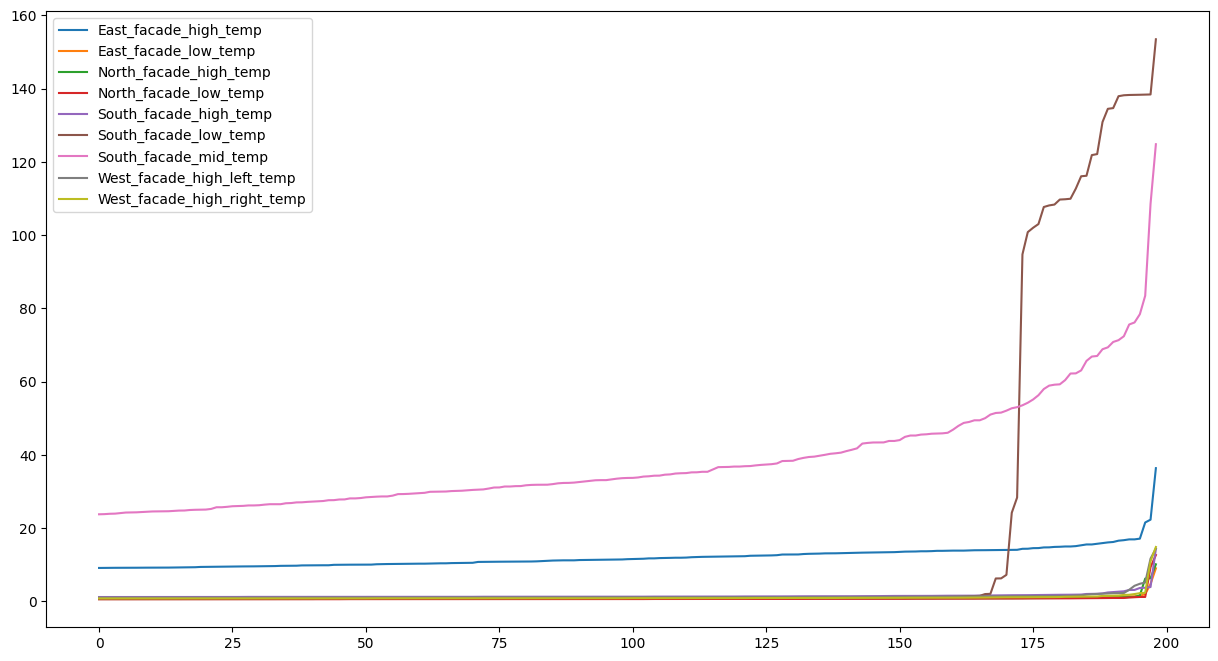

In [12]:
df.plot(figsize=(15, 8))

In [13]:
#Observe the .9 quantile (where 90% of the differences lie in)
df.quantile(0.9)

East_facade_high_temp           14.774756
East_facade_low_temp             1.069199
North_facade_high_temp           0.930603
North_facade_low_temp            0.815756
South_facade_high_temp           1.801788
South_facade_low_temp          108.155501
South_facade_mid_temp           58.956482
West_facade_high_left_temp       1.469156
West_facade_high_right_temp      1.168207
Name: 0.9, dtype: float64

In [14]:
df.quantile(0.9).mean()

21.015716383192345

In [15]:
#Observe the current statistical summary of the data
df.describe()

East_facade_high_temp  East_facade_low_temp  North_facade_high_temp  \
count             199.000000            199.000000              199.000000   
mean               12.048147              0.973087                0.859858   
std                 2.844404              0.649903                0.868281   
min                 9.127796              0.792000                0.633606   
25%                10.018801              0.831600                0.673187   
50%                11.523594              0.871208                0.732590   
75%                13.414495              0.950409                0.801895   
max                36.372585              9.028809               10.117798   

       North_facade_low_temp  South_facade_high_temp  South_facade_low_temp  \
count             199.000000              199.000000             199.000000   
mean                0.781554                1.506840              17.077199   
std                 1.051762                1.007248              41.141325   
min                 0.574203                1.188011               0.831589   
25%                 0.613792                1.227608               0.871193   
50%                 0.633606                1.287003               0.950394   
75%                 0.712803                1.475109               1.108795   
max                12.652206               14.335205             153.469772   

       South_facade_mid_temp  West_facade_high_left_temp  \
count             199.000000                  199.000000   
mean               38.459260                    1.381772   
std                15.077903                    1.290271   
min                23.779800                    1.009811   
25%                28.313995                    1.069187   
50%                33.699615                    1.128601   
75%                43.797600                    1.247391   
max               124.819191                   14.394592   

       West_facade_high_right_temp  
count                   199.000000  
mean                      1.065022  
std                       1.234372  
min                       0.791992  
25%                       0.811813  
50%                       0.871193  
75%                       0.970211  
max                      14.849983

In [16]:
#Observe the .8 quantile (where 80% of the differences lie in)
q_values = df.quantile(0.8)

In [17]:
q_values

East_facade_high_temp          13.816432
East_facade_low_temp            0.990001
North_facade_high_temp          0.831604
North_facade_low_temp           0.752396
South_facade_high_temp          1.532513
South_facade_low_temp           1.207802
South_facade_mid_temp          45.939944
West_facade_high_left_temp      1.294919
West_facade_high_right_temp     1.009792
Name: 0.8, dtype: float64

In [18]:
# Update 'Lst_name' to contain the names of columns
Lst_name = Zone_Temp.columns.values

In [19]:
#If the absolute difference between consecutive values is greater than 10, drop them.
for i in range(0,len(Lst_name)):
    df = Zone_Temp[Lst_name[i]]
#     print (df.diff(), q_values[i])
    print (df[abs(df.diff())> 10].index)
    Zone_Temp[Lst_name[i]] = df.drop(df[abs(df.diff())> 10].index)

DatetimeIndex([], dtype='datetime64[ns, US/Eastern]', name='Timestamp', freq=None)
DatetimeIndex([], dtype='datetime64[ns, US/Eastern]', name='Timestamp', freq=None)
DatetimeIndex(['2023-09-13 10:59:00-04:00'], dtype='datetime64[ns, US/Eastern]', name='Timestamp', freq=None)
DatetimeIndex(['2024-04-15 18:43:00-04:00'], dtype='datetime64[ns, US/Eastern]', name='Timestamp', freq=None)
DatetimeIndex(['2023-09-13 10:59:00-04:00'], dtype='datetime64[ns, US/Eastern]', name='Timestamp', freq=None)
DatetimeIndex([], dtype='datetime64[ns, US/Eastern]', name='Timestamp', freq=None)
DatetimeIndex(['2023-07-20 23:43:00-04:00', '2023-07-20 23:53:00-04:00',
               '2023-07-20 23:55:00-04:00', '2023-07-21 00:00:00-04:00',
               '2023-07-21 00:05:00-04:00', '2023-07-21 00:06:00-04:00',
               '2023-07-21 00:12:00-04:00', '2023-07-21 00:13:00-04:00',
               '2023-07-21 00:26:00-04:00', '2023-07-21 01:05:00-04:00',
               ...
               '2023-07-22 10:15:00-0

<Axes: xlabel='Timestamp'>

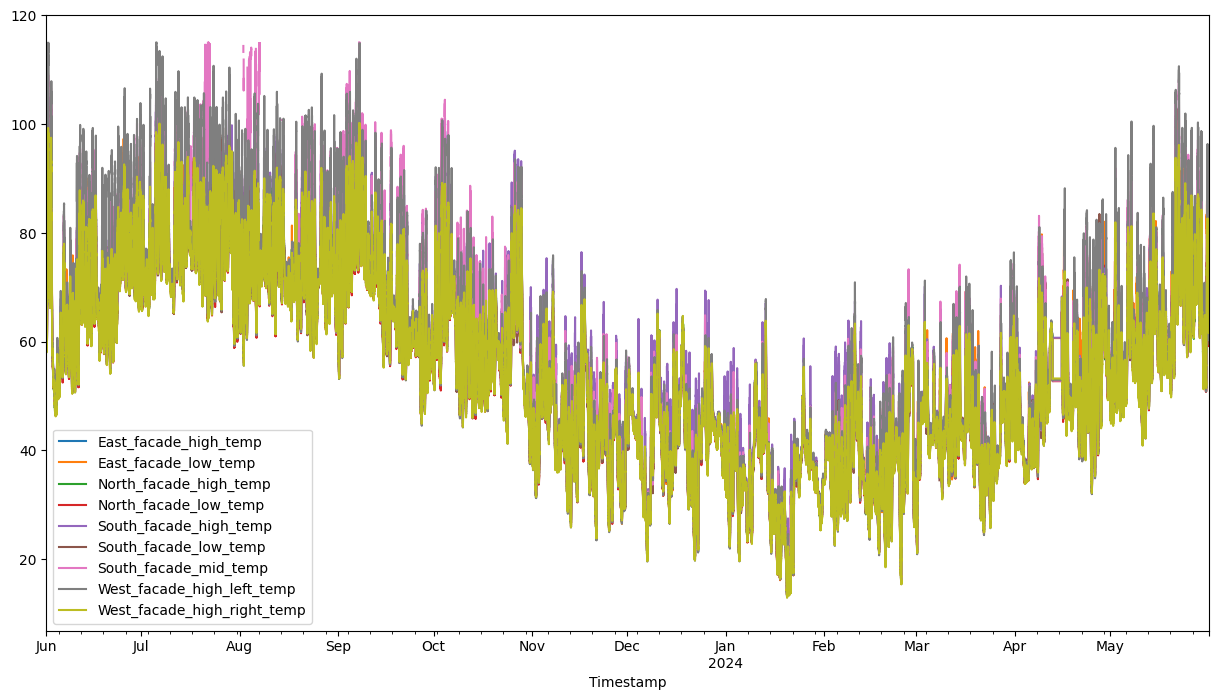

In [20]:
Zone_Temp.plot(figsize=(15, 8))

C:\Users\Sang\AppData\Local\Temp\ipykernel_17168\589575710.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Zone_Temp = Zone_Temp.resample("H").mean().ffill()


<Axes: xlabel='Timestamp'>

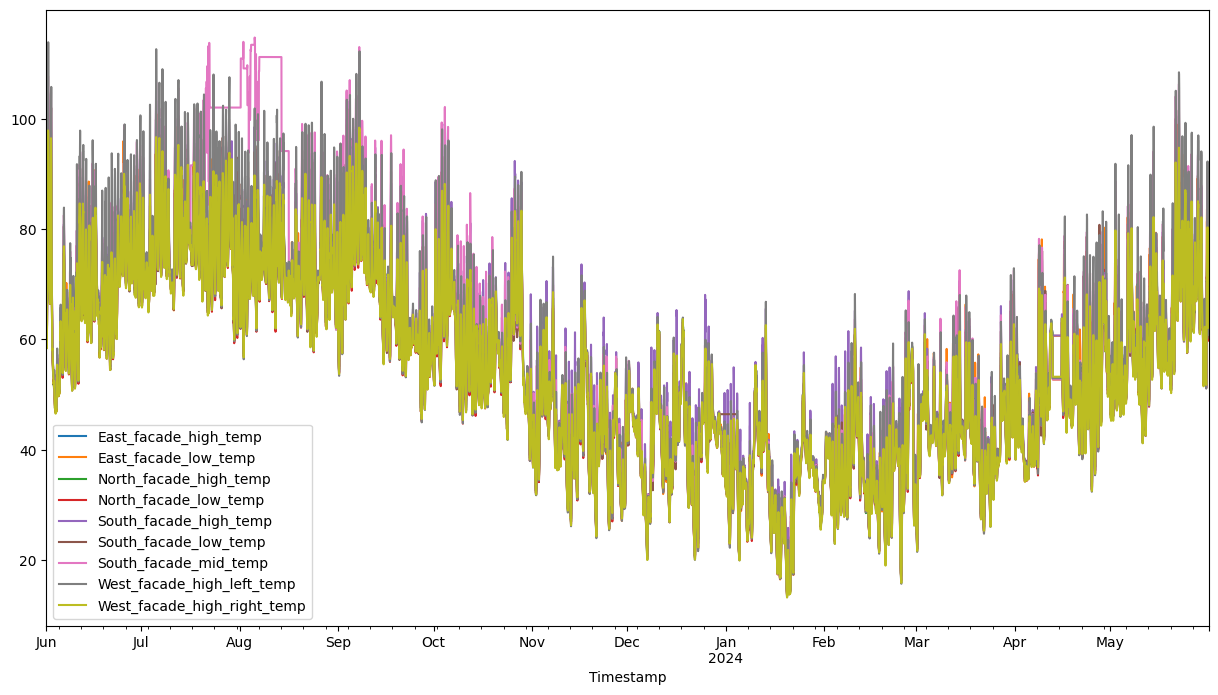

In [21]:
#Process to Hourly and forward fill (average to hour and forward fill to assign last existing value to a missing value)
Zone_Temp = Zone_Temp.resample("H").mean().ffill()

Zone_Temp.plot(figsize=(15, 8))

In [22]:
Zone_Temp.isna().sum()

East_facade_high_temp          8784
East_facade_low_temp              0
North_facade_high_temp            0
North_facade_low_temp             0
South_facade_high_temp            0
South_facade_low_temp             0
South_facade_mid_temp             0
West_facade_high_left_temp        0
West_facade_high_right_temp       0
dtype: int64

In [23]:
#Missing data check
# Detecting rows with repeated values
repeated_index = (Zone_Temp.diff() == 0).all(axis=1)
repeated_rows = Zone_Temp[repeated_index]

# Now let's get the index of the repeated rows
repeated_rows_index = repeated_rows.index.tolist()

Zone_Temp[repeated_index] = np.nan

In [24]:
Zone_Temp.isna().sum()

East_facade_high_temp          8784
East_facade_low_temp              0
North_facade_high_temp            0
North_facade_low_temp             0
South_facade_high_temp            0
South_facade_low_temp             0
South_facade_mid_temp             0
West_facade_high_left_temp        0
West_facade_high_right_temp       0
dtype: int64

<Axes: xlabel='Timestamp'>

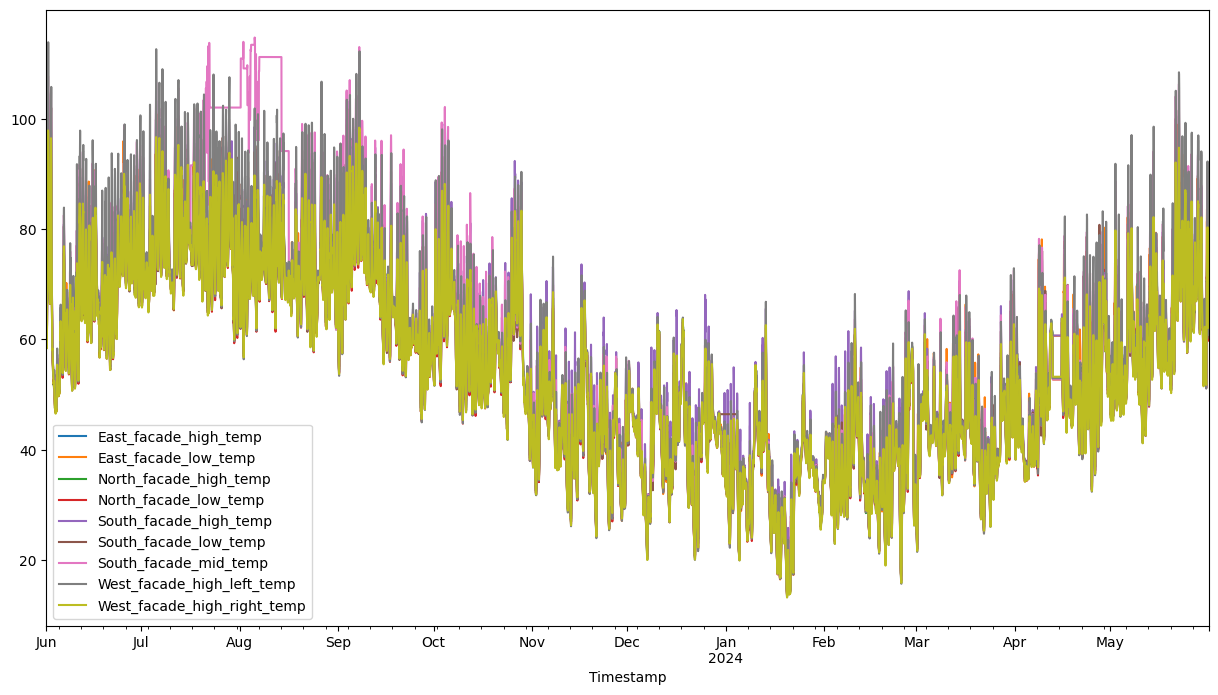

In [25]:
Zone_Temp.plot(figsize=(15, 8))

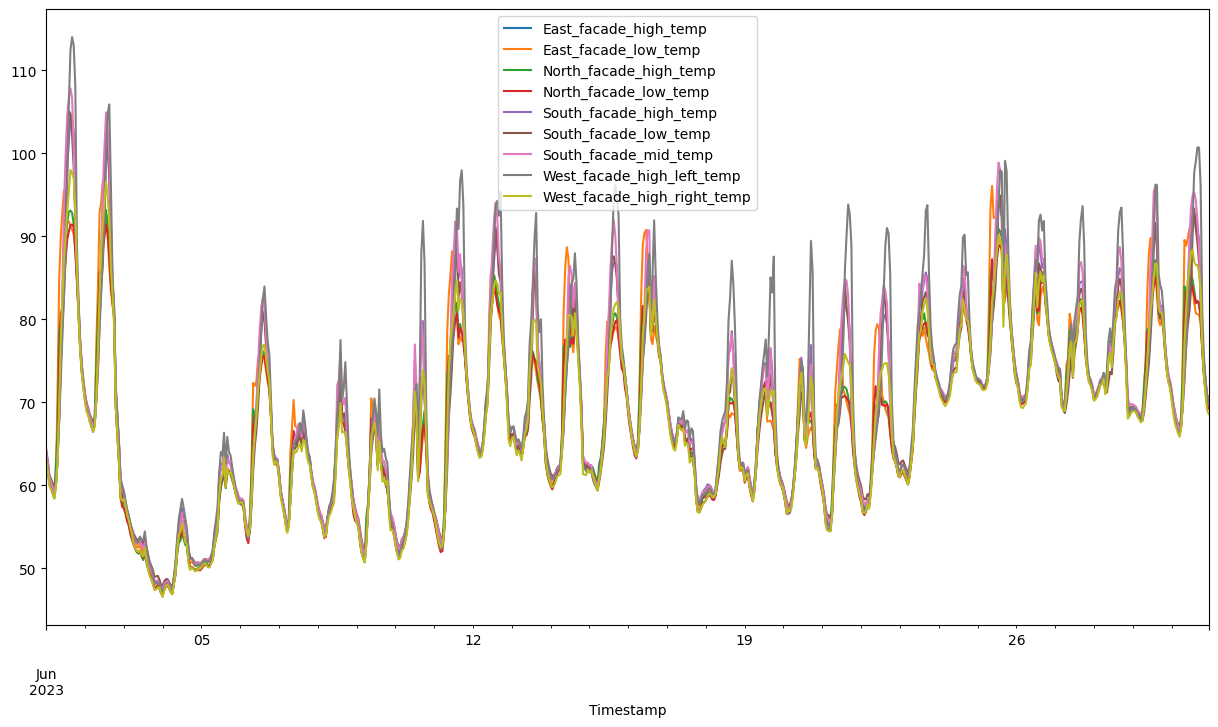

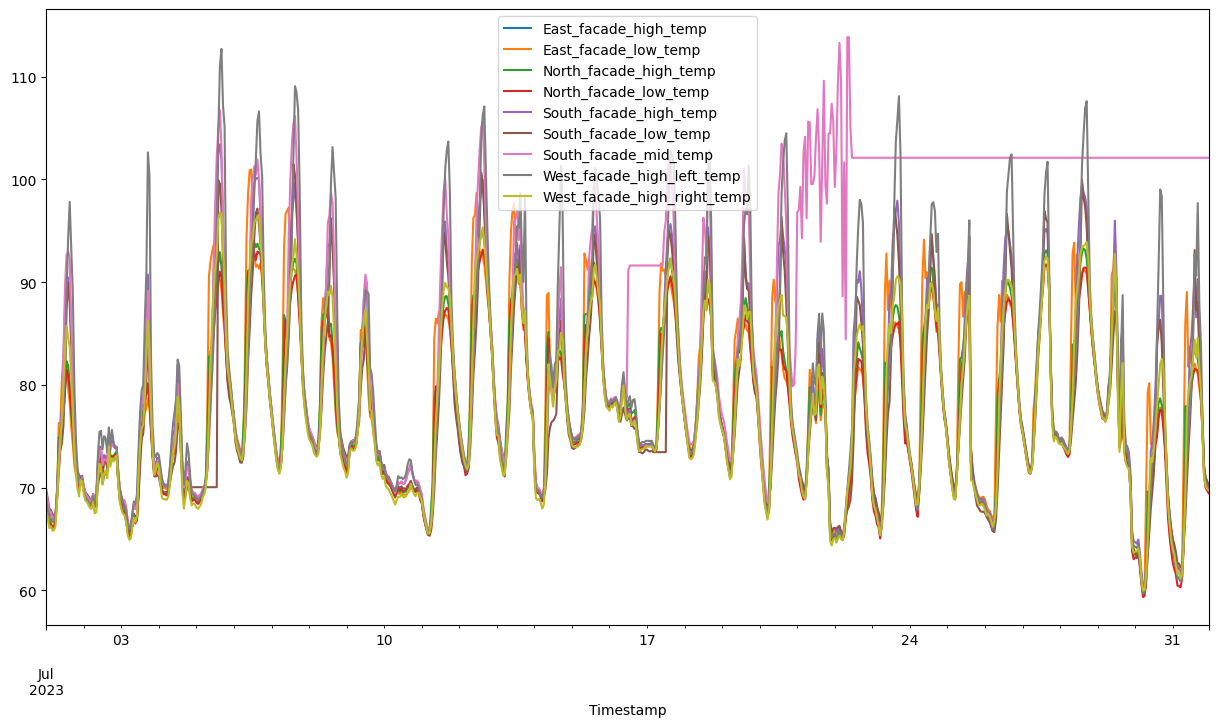

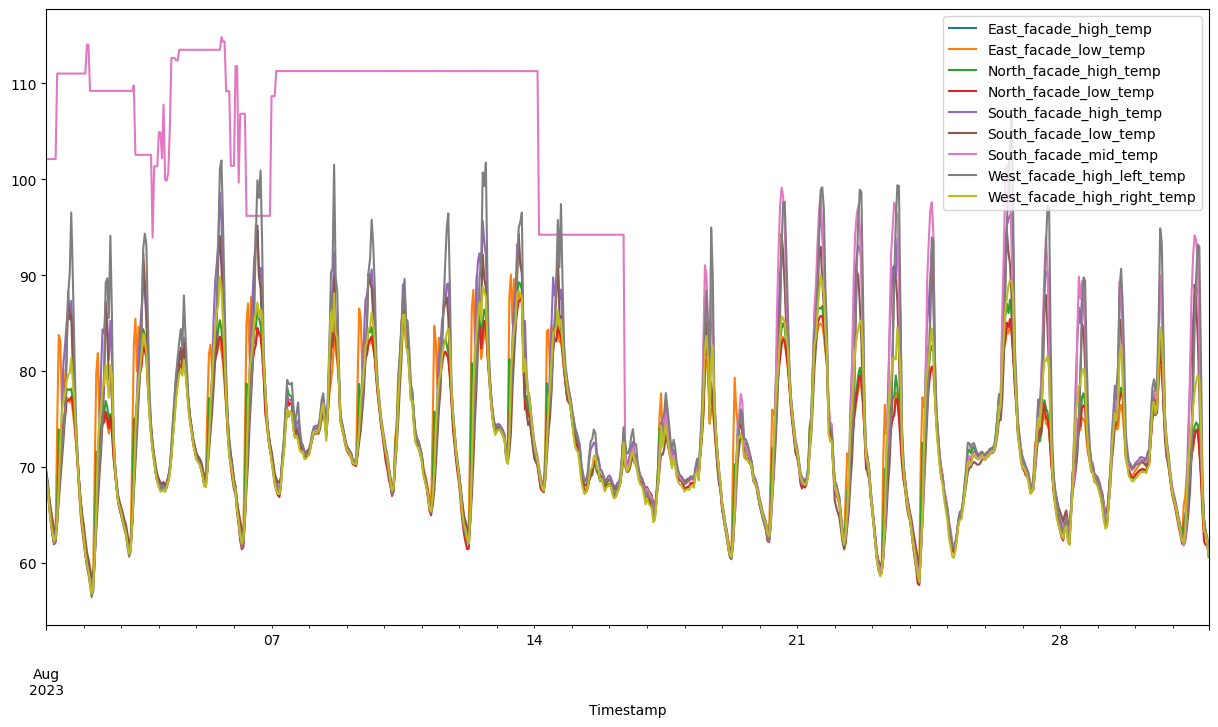

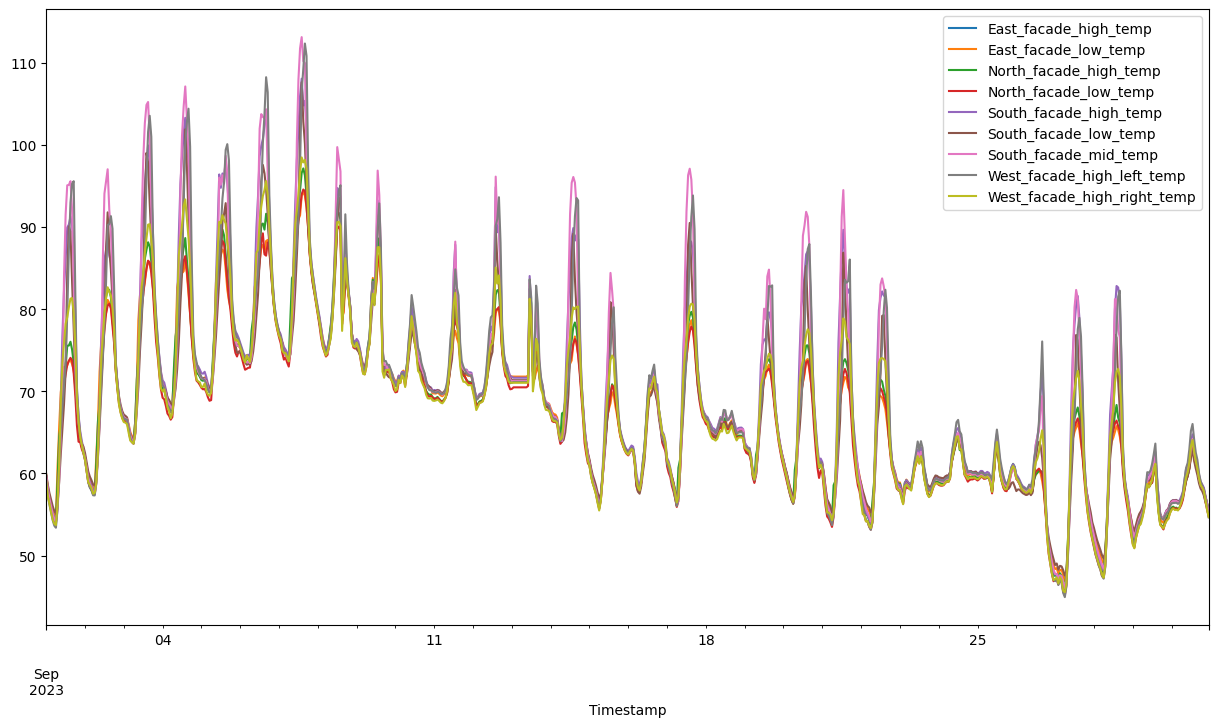

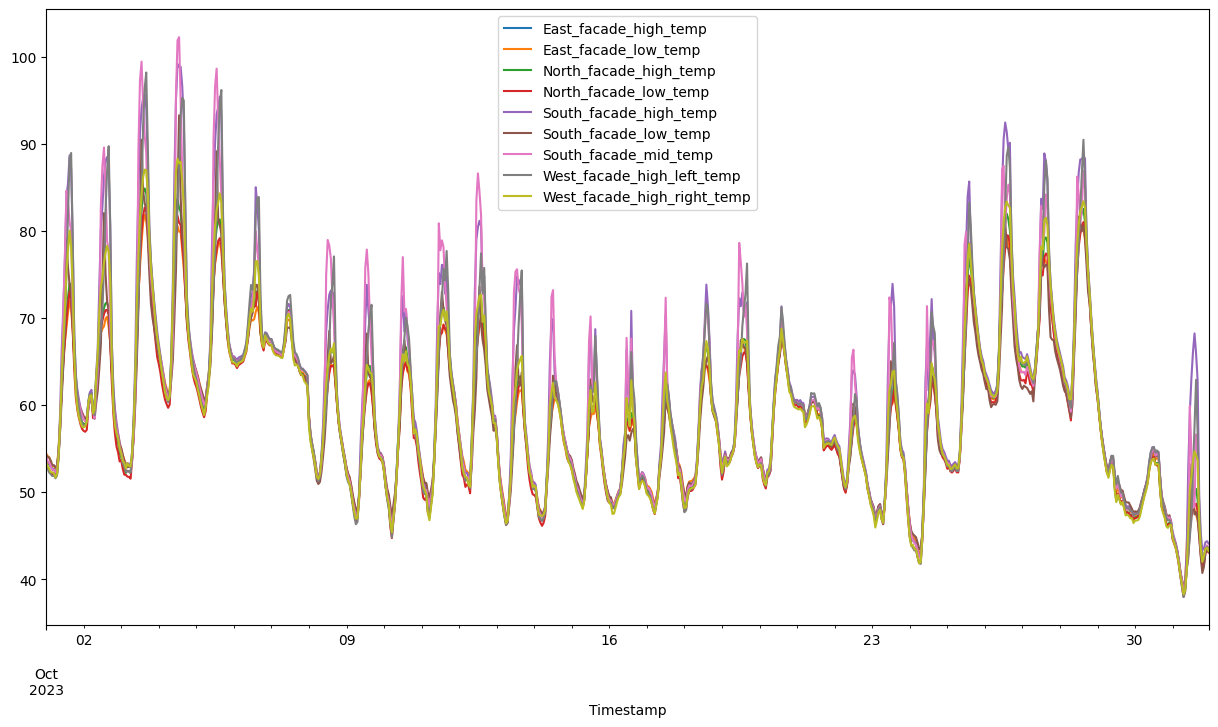

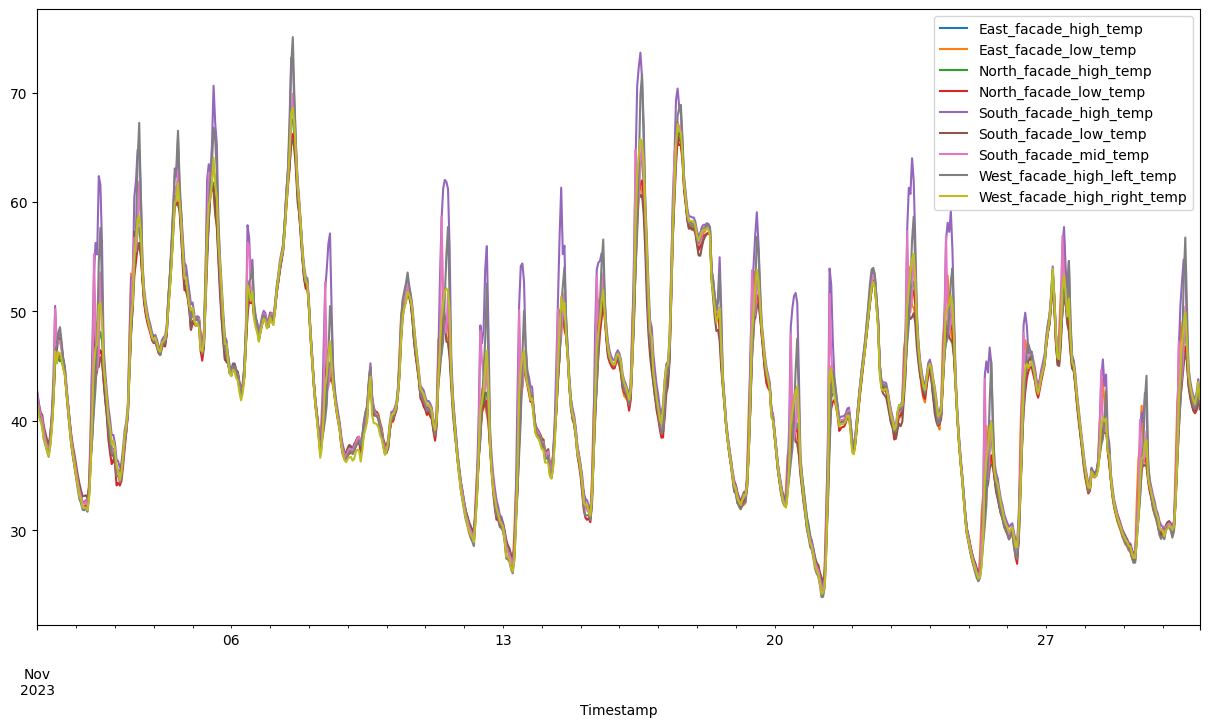

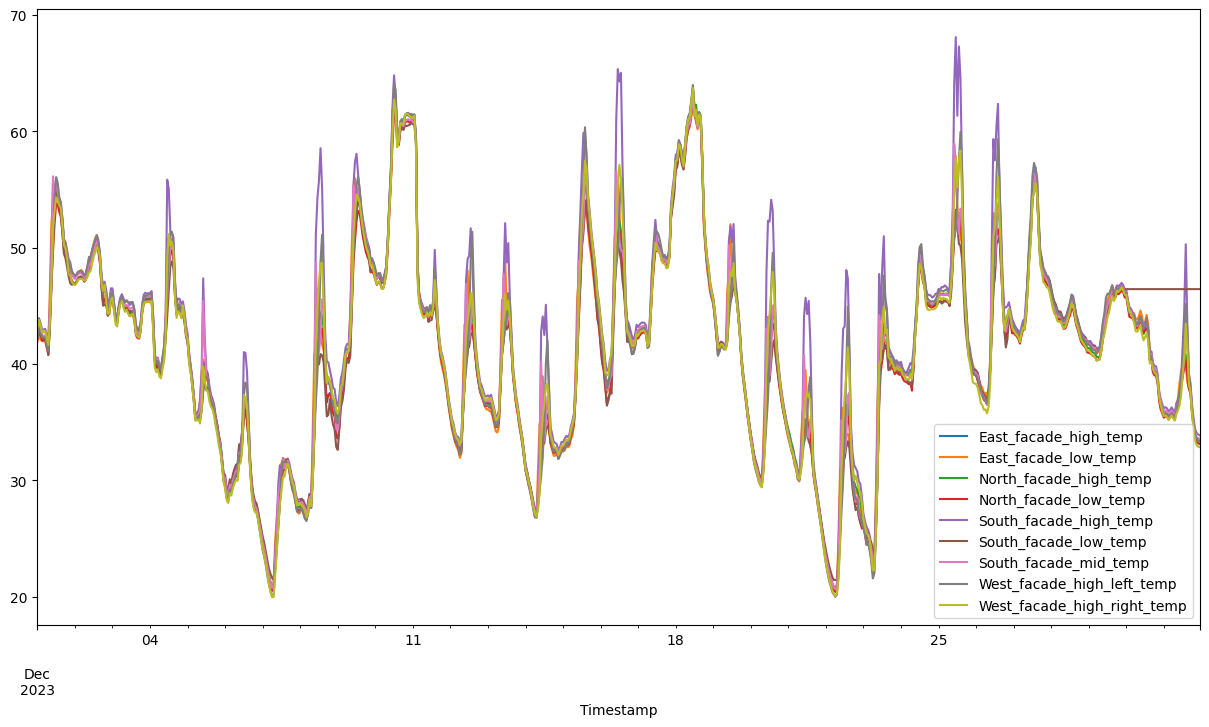

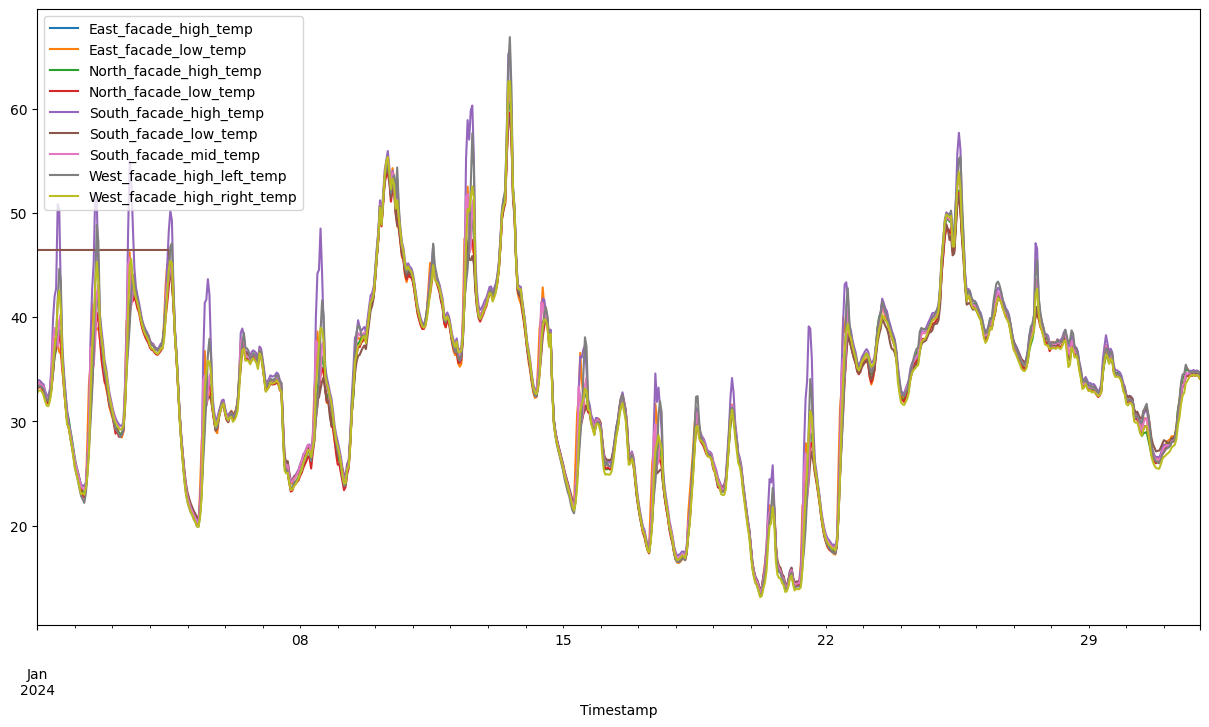

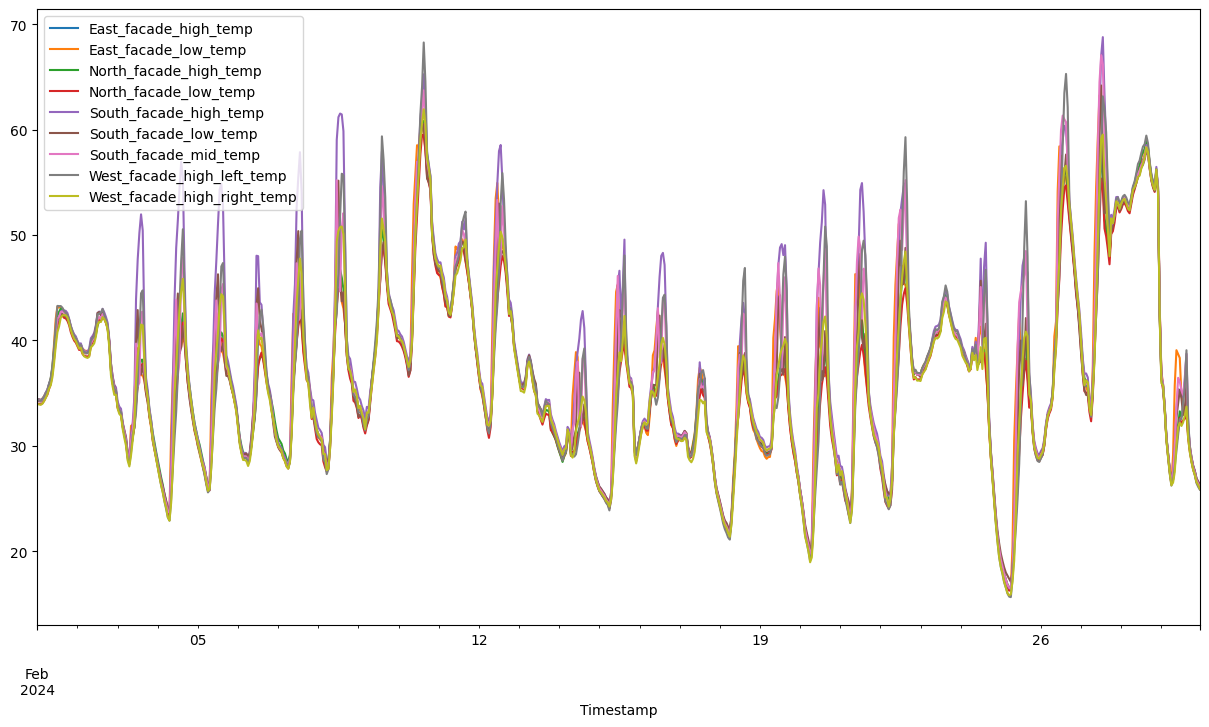

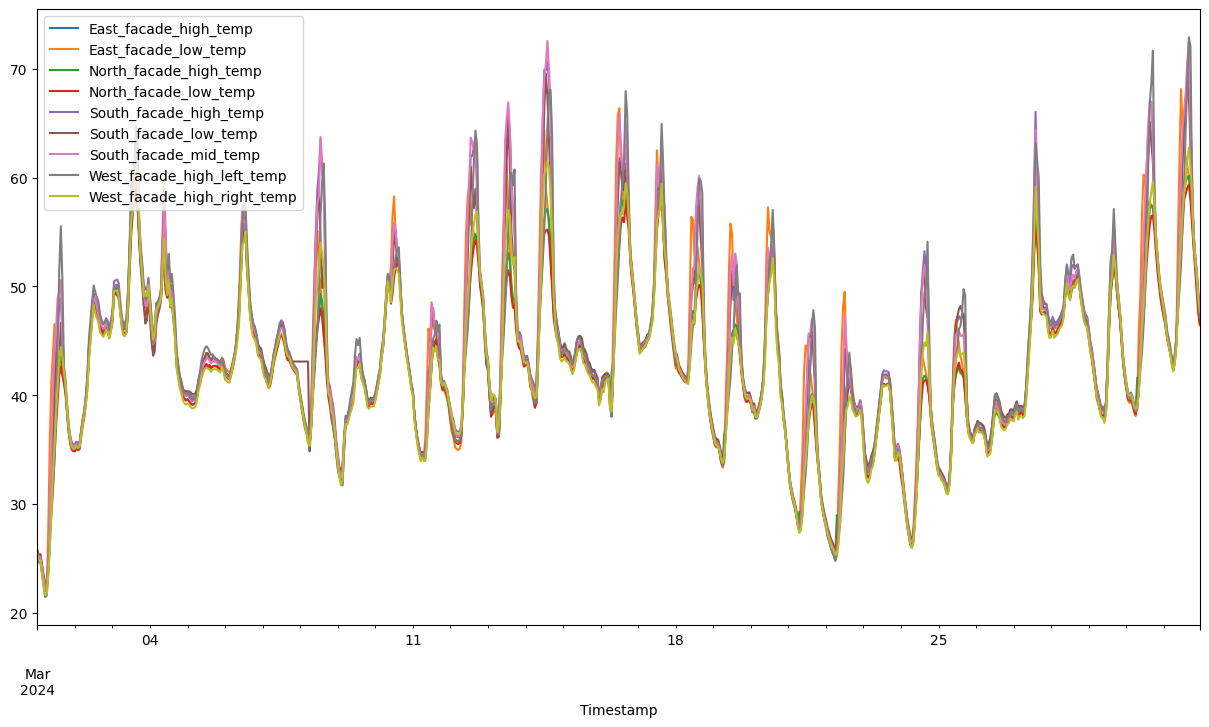

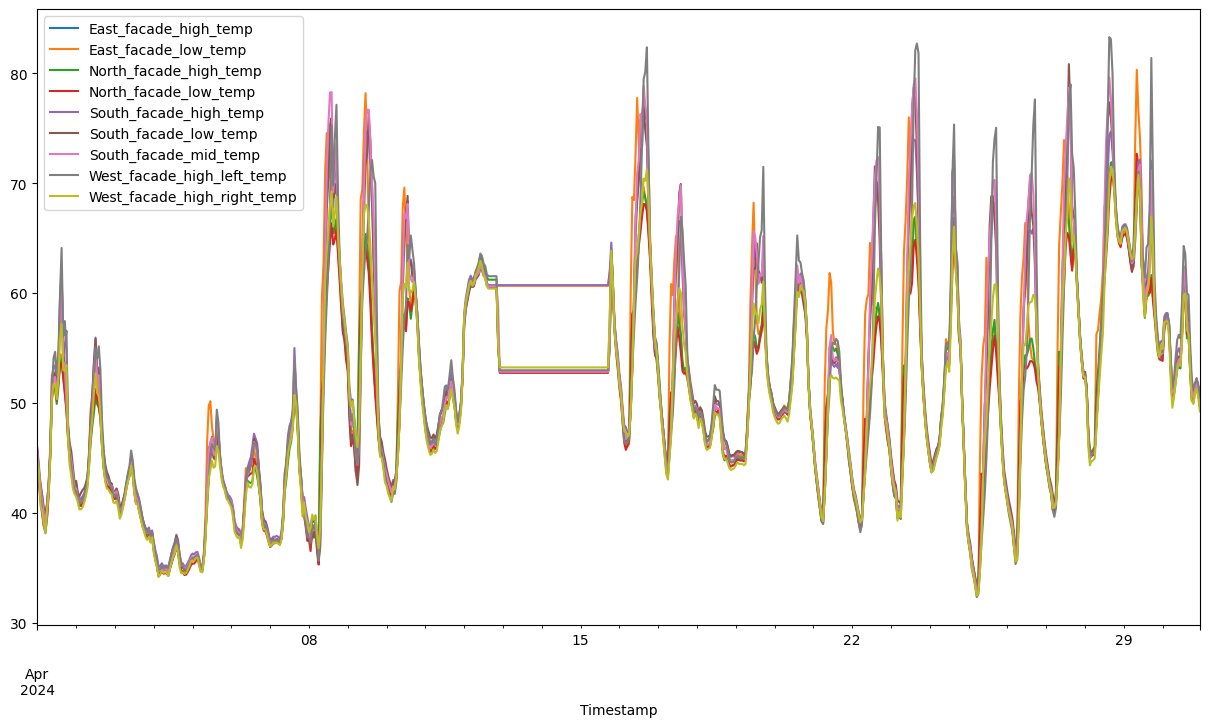

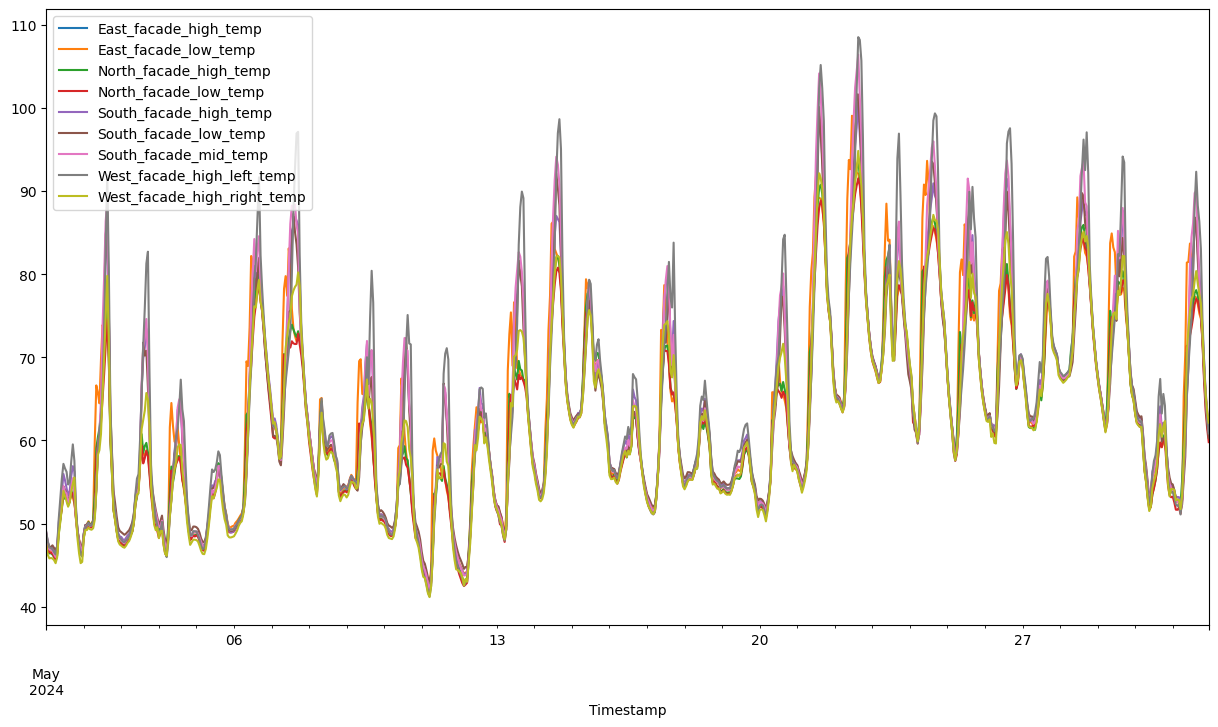

In [26]:
# Then, group by year and week number and apply Mahalanobis distance function
for (year, month), group in Zone_Temp.groupby([Zone_Temp.index.year, Zone_Temp.index.month]):

    group.plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

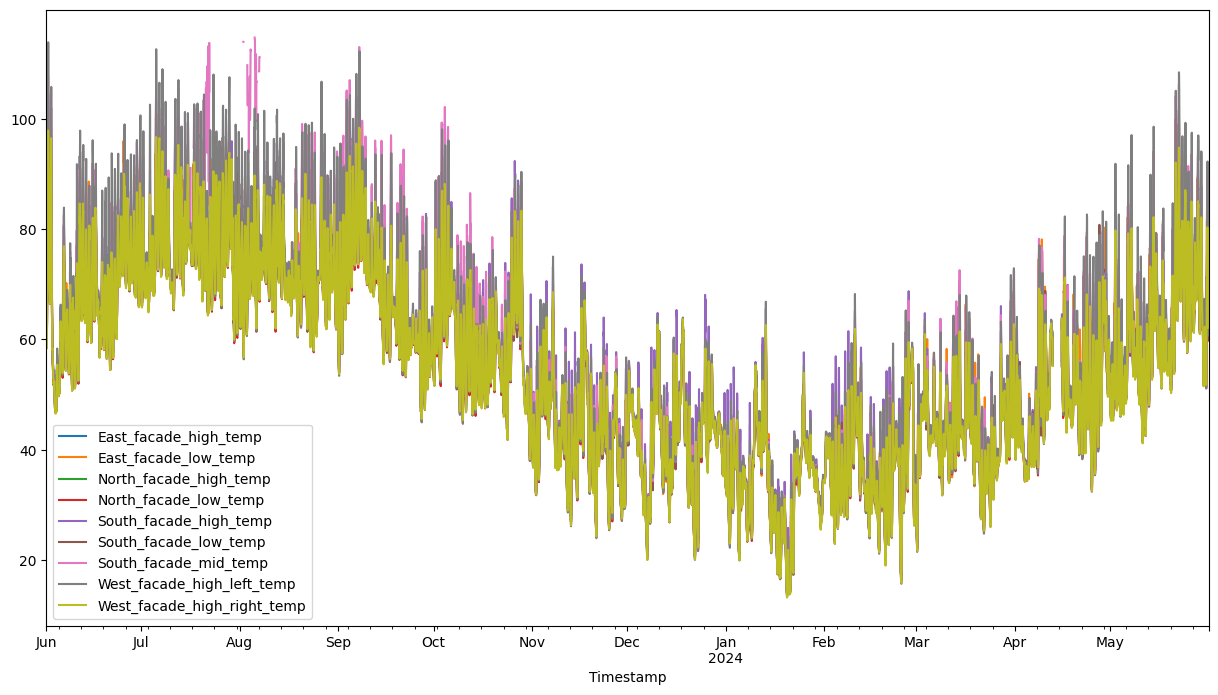

In [27]:
#define a threshold based on the data (assume sensor error)
#define the function to assign all stuck values to null values
def replace_stuck_values_with_nan(series, threshold=5):
    replaced_values = series.copy()
    count = 1  # Counter for consecutive same values
    for i in range(1, len(series)):
        if series.iloc[i] == series.iloc[i - 1]:
            count += 1
        else:
            if count > threshold:  # Replace with NaN if the count exceeds the threshold
                replaced_values.iloc[i - count:i] = np.nan
            count = 1  # Reset counter if the current value is not the same

    if count > threshold:  # Check at the end of the series
        replaced_values.iloc[-count:] = np.nan

    return replaced_values


def replace_repeated_values_with_nan(df):
    for column in df.columns:
        # Find duplicated values in the column (keep=False marks all duplicates as True)
        duplicates = df[column].duplicated(keep=False)
        # Replace duplicates with NaN
        df.loc[duplicates, column] = np.nan
    return df

for column in Zone_Temp.columns:
    Zone_Temp[column] = replace_stuck_values_with_nan(Zone_Temp[column], threshold=12)
    
Zone_Temp.plot(figsize=(15, 8))

In [28]:
Zone_Temp.isna().sum()

East_facade_high_temp          8784
East_facade_low_temp             75
North_facade_high_temp           68
North_facade_low_temp            68
South_facade_high_temp           75
South_facade_low_temp           223
South_facade_mid_temp           637
West_facade_high_left_temp       68
West_facade_high_right_temp      68
dtype: int64

In [29]:
def find_nan_sequences(series):
    is_nan = series.isna()
    if is_nan.any():
        start = end = None
        for i, val in enumerate(is_nan):
            if val and start is None:
                start = i
            elif not val and start is not None:
                end = i - 1
                yield (series.index[start], series.index[end])
                start = end = None
        if start is not None:
            yield (series.index[start], series.index[-1])

# Find and print start and end indices of NaN sequences in each column
empDF = pd.DataFrame()
LstN = []
LstS = []
LstE = []

for column in Zone_Temp.columns:
    for start, end in find_nan_sequences(Zone_Temp[column]):
        print(f"Missing period:'{column}' from {start} to {end}")
        LstN.append(column)
        LstS.append(start)
        LstE.append(end)
        
empDF["names"] = LstN
empDF["start"] = LstS
empDF["end"] = LstE

Missing period:'East_facade_high_temp' from 2023-06-01 00:00:00-04:00 to 2024-05-31 23:00:00-04:00
Missing period:'East_facade_low_temp' from 2024-04-12 15:00:00-04:00 to 2024-04-15 17:00:00-04:00
Missing period:'North_facade_high_temp' from 2024-04-12 22:00:00-04:00 to 2024-04-15 17:00:00-04:00
Missing period:'North_facade_low_temp' from 2024-04-12 22:00:00-04:00 to 2024-04-15 17:00:00-04:00
Missing period:'South_facade_high_temp' from 2024-04-12 15:00:00-04:00 to 2024-04-15 17:00:00-04:00
Missing period:'South_facade_low_temp' from 2023-07-04 18:00:00-04:00 to 2023-07-05 13:00:00-04:00
Missing period:'South_facade_low_temp' from 2023-12-29 22:00:00-05:00 to 2024-01-04 12:00:00-05:00
Missing period:'South_facade_low_temp' from 2024-04-12 22:00:00-04:00 to 2024-04-15 17:00:00-04:00
Missing period:'South_facade_mid_temp' from 2023-07-16 13:00:00-04:00 to 2023-07-17 10:00:00-04:00
Missing period:'South_facade_mid_temp' from 2023-07-22 11:00:00-04:00 to 2023-08-02 01:00:00-04:00
Missing p

In [30]:
empDF.to_csv(r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Missing Intervals\Year4\Missing_periods_FT_Year4.csv', index=False)

In [31]:
Zone_Temp.to_csv(r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Processed\Desigo\Year4\Zone_FT_Year4.csv', index=True)